_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: FILL IN YOUR NAMES HERE

# Coding Lab 8



In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style("whitegrid")
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-06-27 16:25:44Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

sklearn: 1.4.2

numpy     : 1.26.4
seaborn   : 0.13.2
matplotlib: 3.9.0

Watermark: 2.4.3



# Task 1: Implement entropy estimators


*Grading: 5 pts (basic) + 1 pts (advanced) + 3 pts (bonus)*

## General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


## Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## Basic
*Grading: 5 pts*

### MLE

*Grading: 1 pts*

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [173]:
def entropy_mle(phat):
    """Maximum likelihood or plug-in estimator of discrete entropy

    Parameter
    ---------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    Return
    ------
    H: float
        Entropy estimate
    """
    # insert your code here (1 pt)

    nonzero_phat = phat[phat > 0]
    H = -np.sum(nonzero_phat * np.log2(nonzero_phat))

    return H

### Miller-Maddow corrected

*Grading: 1 pts*

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [174]:
# own functions
def f(z):
    """
    Converts a binary sequence to its corresponding integer.

    Parameters
    ----------
    binary_sequence: list or np.array
        A binary sequence (list or array of 0s and 1s).

    Returns
    -------
    integer_value: int
        The integer representation of the binary sequence.
    """
    return sum(z[i] * (2**i) for i in range(len(z)))


def f_phat(sequences):
    """
    Computes the probability of each binary sequence p(X=x).

    Parameters
    ----------
    sequences: list of lists or np.array
        A list of binary sequences (each sequence is a list or array of 0s and 1s).

    Returns
    -------
    probabilities: np.array
        An array of probabilities corresponding to each possible binary sequence.
    """
    # Transform each binary sequence to its corresponding integer value
    f_Z = np.array([f(z) for z in sequences])

    # Count the occurrences of each integer value
    unique_values, counts = np.unique(f_Z, return_counts=True)

    # Determine the length of the output array (all possible outcomes)
    max_value = 2 ** len(
        sequences[0]
    )  # Maximum integer value for the given sequence length

    # Initialize probabilities array with zeros
    phat = np.zeros(max_value)

    # Calculate probabilities
    phat[unique_values] = counts / len(sequences)

    return phat

In [175]:
def entropy_mm(phat, n):
    """Miller-Maddow corrected estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n:  int
        Number of samples


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)
    H_mle = entropy_mle(phat)
    dhat = len(phat[phat > 0])

    H = H_mle + (dhat - 1) / (2 * n)

    return H

### Jack-knife corrected

*Grading: 2 pts*

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [176]:
# def entropy_jk(x, edges):
#     """Jack-knife corrected estimator of discrete entropy

#     Parameters
#     ----------
#     x: np.array, shape=(n_samples, )
#         Samples

#     edges: np.array, shape=(n_bins, )
#         Histogram bin edges


#     Return
#     ------

#     H: float
#         Entropy estimate
#     """

#     phat = f_phat(x)

#     # insert your code here (2 pt)
#     N = len(phat)

#     # Compute the histogram
#     hist, _ = np.histogram(phat, bins=edges, density=True)

#     # Compute the MLE entropy for the full sample
#     full_entropy = entropy_mle(phat)

#     # Compute the leave-one-out entropies
#     leave_one_out_entropies = []
#     for i in range(N):
#         phat_leave_one_out = np.delete(phat, i)
#         hist_leave_one_out, _ = np.histogram(
#             phat_leave_one_out, bins=edges, density=True
#         )
#         leave_one_out_entropy = entropy_mle(hist_leave_one_out)
#         leave_one_out_entropies.append(leave_one_out_entropy)

#     # Average leave-one-out entropy
#     mean_leave_one_out_entropy = np.mean(leave_one_out_entropies)

#     # Jackknife entropy estimate
#     H = N * full_entropy - (N - 1) * mean_leave_one_out_entropy

#     return H

In [177]:
def entropy_jk(x, edges):
    """Jack-knife corrected estimator of discrete entropy

    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples

    edges: np.array, shape=(n_bins, )
        Histogram bin edges


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (2 pt)
    phat = f_phat(x)
    N = len(phat)

    # Compute the MLE entropy for the full sample
    full_entropy = entropy_mle(phat)

    # Compute the leave-one-out entropies
    leave_one_out_entropies = []
    for i in range(len(x)):
        x_leave_one_out = np.delete(x, i, axis=0)
        phat_leave_one_out = f_phat(x_leave_one_out)
        leave_one_out_entropy = entropy_mle(phat_leave_one_out)
        leave_one_out_entropies.append(leave_one_out_entropy)

    # Average leave-one-out entropy
    mean_leave_one_out_entropy = np.mean(leave_one_out_entropies)

    # Jackknife entropy estimate
    H = N * full_entropy - (N - 1) * mean_leave_one_out_entropy

    return H

### Coverage-adjusted

*Grading: 1 pts*

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [178]:
def entropy_cae(phat, n):
    """coverage-adjusted estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n: int
        Number of samples.


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)
    single_occurrences = np.sum(phat == (1 / n))
    C = 1 - (single_occurrences / n)
    phat_c = phat * C

    # Coverage-adjusted entropy
    H = -np.sum(
        [(pc * np.log2(pc)) / (1 - (1 - pc) ** n) if pc > 0 else 0 for pc in phat_c]
    )

    return H

## Advanced
*Grading: 1 + 3 pts*

### JVHW
*Grading: 1 pts*

In [179]:
def entropy_jvhw(x):
    """JVHW estimator of discrete entropy.

    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples

    Return
    ------
    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    return H

### Bonus points: Unseen or Best Upper Bounds estimator
*Grading: 3 bonus pts*

In [180]:
# insert your code here

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)
# ------------------------------------------

# Task 2: Distributions
*Grading: 4 pts*

## Uniform distribution
*Grading: 2 pts*

In [181]:
D = 10
N = 2**D

p = 1 / N * np.ones(N)  # true distribution

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

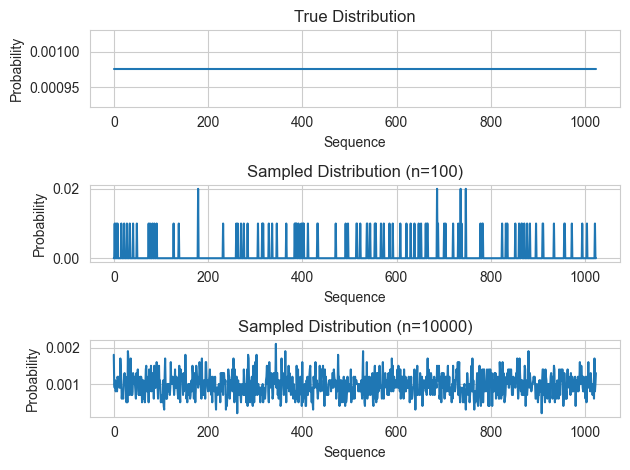

In [182]:
# insert your code here
rng = np.random.default_rng(0)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
sample_size_100 = rng.choice(N, size=100, replace=True)
sampled_dist_100, _ = np.histogram(sample_size_100, bins=np.arange(N + 1), density=True)
# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------
sample_size_10000 = rng.choice(N, size=10000, replace=True)
sampled_dist_10000, _ = np.histogram(
    sample_size_10000, bins=np.arange(N + 1), density=True
)
# ------------------------------------
# Plot the true distribution and
# the sampled distributions. (0.5 pts)
# ------------------------------------
plt.subplot(3, 1, 1)
plt.plot(p, label="True Distribution")
plt.title("True Distribution")
plt.xlabel("Sequence")
plt.ylabel("Probability")

# Plot sampled distribution with sample size 100
plt.subplot(3, 1, 2)
plt.plot(sampled_dist_100, label="Sampled Distribution (n=100)")
plt.title("Sampled Distribution (n=100)")
plt.xlabel("Sequence")
plt.ylabel("Probability")

# Plot sampled distribution with sample size 10000
plt.subplot(3, 1, 3)
plt.plot(sampled_dist_10000, label="Sampled Distribution (n=10000)")
plt.title("Sampled Distribution (n=10000)")
plt.xlabel("Sequence")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [183]:
sample_sizes = np.round(np.logspace(1, 5, num=10)).astype(int)
n_runs = 30
rng = np.random.default_rng(1)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
# h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------
        x = rng.choice([0, 1], size=(S, 10))  # Generate binary sequences
        phat = f_phat(x)

        # insert your code here

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        if i < 7:
            h_jk[i, j] = entropy_jk(x, edges)
    print(i)
    # h_jvhw[i, j] = entropy_jvhw(x)

0
1
2
3
4
5
6
7
8
9


Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

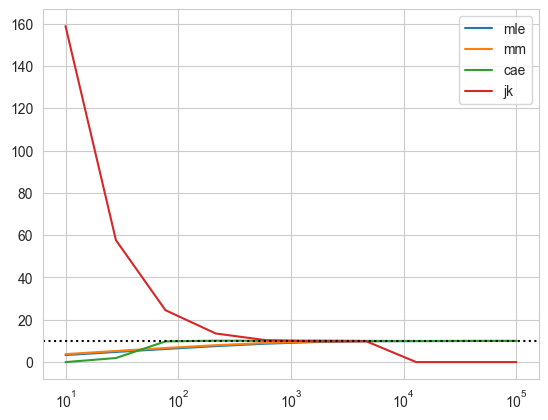

In [184]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
# plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":")

plt.legend()

## Zipf distribution
*Grading: 2 pts*

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [185]:
D = 10
N = 2**D

p = 1 / (np.arange(0, N) + 1)  # true distribution
p = p / np.sum(p)

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `choice` of numpys random number generator is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

In [186]:
# insert your code here
rng = np.random.default_rng(2)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------


# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------


# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [187]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(3)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
# h_cae = np.zeros((len(sample_sizes), n_runs))
# h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------

        # insert your code here

        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_jk[i, j] = entropy_jk(x, edges)
        h_jvhw[i, j] = entropy_jvhw(x)

KeyboardInterrupt: 

Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

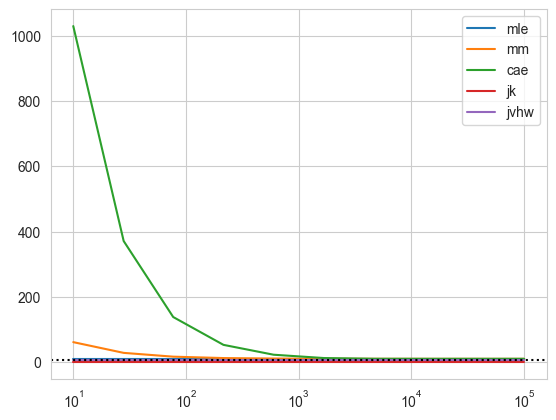

In [ ]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":")
plt.legend()